# ATP Tennis Data - Player Diff Stats


In our feature engineering notebooks, we created a dataset for match where we left categorical columns un-encoded. We will run this dataset through various classification models and see how the models perform. I suspect tree based models (especially ensemble models) will perform the best as our data is non-linear

NOTE: since we are not one hot encoding our categories.. this is probably an invalid test. We are purely just getting a quick baseline since this dataset is small


# Summary of Results

* Our best results came from Gradient Boosting with the results below. 
* Only Logistic Regression and Gradient Boosting performed better than our baseline
*  Decision Tree, KNN, and AdaBoost all did below our baseline

```
Model Score: 0.6843349088453747

ROC/AUC Score: 0.6843094896328699
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.68      7381
         Win       0.68      0.69      0.69      7429

    accuracy                           0.68     14810
   macro avg       0.68      0.68      0.68     14810
weighted avg       0.68      0.68      0.68     14810

```




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, RSTATE, N_JOBS, MAX_ITER, LABEL_COL
import util.model_util as mu
import logging
import importlib

logging.basicConfig(level=logging.INFO)
%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d %H:%m'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "diff-ohe"


# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    DESCRIPTION = f"{DESCRIPTION}-test"
    FEATURE_FILE = '../datasets/atp_matches_1985-2019_features_test-raw_diff-ohe-history-matchup-stats.csv'
    ModelWrapper.REPORT_FILE = '../reports/summary-test.csv'
else:
    FEATURE_FILE = '../datasets/atp_matches_1985-2019_features-raw_diff-ohe-history-matchup-stats.csv'




START_YEAR = 1998
END_YEAR = 2018


column_filters = ["util.model_util.BaseDiffFilter", "util.model_util.OHEFilter"]

In [2]:
X_train, X_test, y_train, y_test = ModelWrapper.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR, column_filters = column_filters)
print(f'Final columns: {X_test.columns}')

INFO:util.model_util:loading ../datasets/atp_matches_1985-2019_features-raw_diff-ohe-history-matchup-stats.csv
INFO:util.model_util:Shape before filtering: (59239, 5459)
INFO:util.model_util:Adding filter: util.model_util.BaseDiffFilter
INFO:util.model_util:Adding filter: util.model_util.OHEFilter
INFO:util.model_util:Shape after filtering: (59239, 5253)
INFO:util.model_util:Final Features shape: (59239, 5253)


Final columns: Index(['draw_size', 'round_label', 'tourney_level_label', 'tourney_month',
       'tourney_year', 'age_diff', 'ht_diff', 'seed_diff', 'rank_diff',
       'p1_hand_l',
       ...
       'p2_200624', 'p2_200630', 'p2_202090', 'p2_202130', 'p2_202358',
       'p2_202359', 'p2_202385', 'p2_205734', 'best_of_3', 'best_of_5'],
      dtype='object', length=5253)


# Get our baseline

If we really don't know anything about tennis, then a reasonable way of predicting wins/losses would be by player rank. If we look at our dataset, the accuracy of using this method for prediction would be the baseline accuracy for our model:

If player 1 rank < player 2 rank, then label == 1 (win)
If player 2 rank < player 1 rank, then label == 0 (loss)
Sum these two numbers and divide by total samples would give us the baseline accuracy


In [3]:
tests = pd.concat([X_test, y_test], axis=1)
p1_wins = tests[(tests.rank_diff  < 0) ]
p2_losses = tests[(tests.rank_diff > 0)]
baseline_accuracy = (len(p1_wins) + len(p2_losses))/ len(tests)
print(f'Our baseline accuracy should be: {baseline_accuracy}')

Our baseline accuracy should be: 0.999932478055368


# Run all Models

In [4]:
models = [
    LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
    KNeighborsClassifier(n_jobs = N_JOBS),
    DecisionTreeClassifier(random_state = RSTATE),
    RandomForestClassifier(random_state=RSTATE, verbose=1),
    GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
    AdaBoostClassifier(random_state=RSTATE),
]



Running LogisticRegression


/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]Model Score: 0.6629979743416611

ROC/AUC Score: 0.6629977169592232
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66      7381
         Win       0.66      0.66      0.66      7429

    accuracy                           0.66     14810
   macro avg       0.66      0.66      0.66     14810
weighted avg       0.66      0.66      0.66     14810

      Loss   Win
Loss  4893  2488
Win   2503  4926


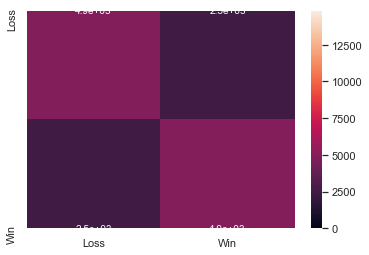

INFO:util.model_util:Saving model file: ../models/logisticregression-1998-2018-diff-ohe.pkl
INFO:util.model_util:Reading report: ../reports/summary.csv


Saving report: ../reports/summary.csv


Running KNeighborsClassifier
Model Score: 0.6068872383524645

ROC/AUC Score: 0.6068721666587122
              precision    recall  f1-score   support

        Loss       0.61      0.60      0.60      7381
         Win       0.61      0.61      0.61      7429

    accuracy                           0.61     14810
   macro avg       0.61      0.61      0.61     14810
weighted avg       0.61      0.61      0.61     14810

      Loss   Win
Loss  4445  2936
Win   2886  4543


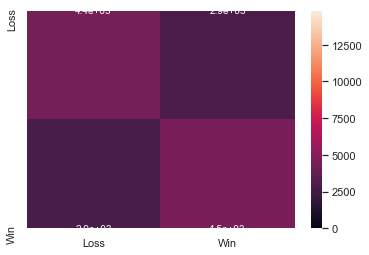

INFO:util.model_util:Saving model file: ../models/kneighborsclassifier-1998-2018-diff-ohe.pkl
INFO:util.model_util:Reading report: ../reports/summary.csv


Saving report: ../reports/summary.csv


Running DecisionTreeClassifier
Model Score: 0.5866981769074949

ROC/AUC Score: 0.5866975557200496
              precision    recall  f1-score   support

        Loss       0.59      0.59      0.59      7381
         Win       0.59      0.59      0.59      7429

    accuracy                           0.59     14810
   macro avg       0.59      0.59      0.59     14810
weighted avg       0.59      0.59      0.59     14810

      Loss   Win
Loss  4329  3052
Win   3069  4360


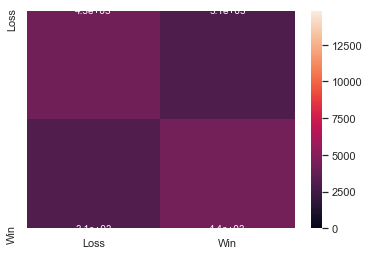

INFO:util.model_util:Saving model file: ../models/decisiontreeclassifier-1998-2018-diff-ohe.pkl
INFO:util.model_util:Reading report: ../reports/summary.csv


Saving report: ../reports/summary.csv


Running RandomForestClassifier


/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.6301147873058744

ROC/AUC Score: 0.630339813204163
              precision    recall  f1-score   support

        Loss       0.61      0.70      0.65      7381
         Win       0.65      0.56      0.60      7429

    accuracy                           0.63     14810
   macro avg       0.63      0.63      0.63     14810
weighted avg       0.63      0.63      0.63     14810

      Loss   Win
Loss  5165  2216
Win   3262  4167


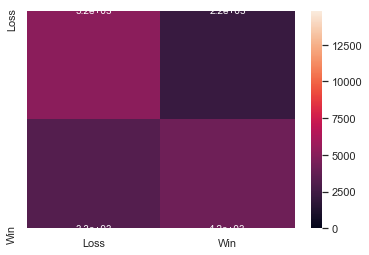

INFO:util.model_util:Saving model file: ../models/randomforestclassifier-1998-2018-diff-ohe.pkl
INFO:util.model_util:Reading report: ../reports/summary.csv


Saving report: ../reports/summary.csv


Running GradientBoostingClassifier
      Iter       Train Loss   Remaining Time 
         1           1.3644            9.51m
         2           1.3465            9.25m
         3           1.3319            9.08m
         4           1.3198            8.96m
         5           1.3099            8.86m
         6           1.3014            8.77m
         7           1.2944            8.67m
         8           1.2886            8.57m
         9           1.2835            8.47m
        10           1.2793            8.35m
        20           1.2578            7.67m
        30           1.2491            6.64m
        40           1.2432            5.58m
        50           1.2392            4.58m
        60           1.2356            3.63m
        70           1.2324            2.70m
        80           1.2298            1.79m
        90           1.2273           53.46s
       100           1.2251            0.00s
Model Score: 0.660297096

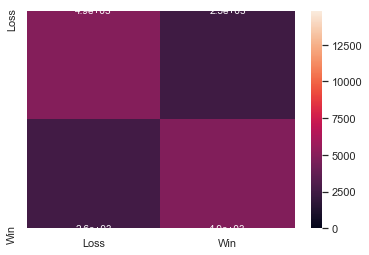

INFO:util.model_util:Saving model file: ../models/gradientboostingclassifier-1998-2018-diff-ohe.pkl
INFO:util.model_util:Reading report: ../reports/summary.csv


Saving report: ../reports/summary.csv


Running AdaBoostClassifier
Model Score: 0.6592167454422687

ROC/AUC Score: 0.6592729102267486
              precision    recall  f1-score   support

        Loss       0.65      0.68      0.66      7381
         Win       0.67      0.64      0.65      7429

    accuracy                           0.66     14810
   macro avg       0.66      0.66      0.66     14810
weighted avg       0.66      0.66      0.66     14810

      Loss   Win
Loss  4994  2387
Win   2660  4769


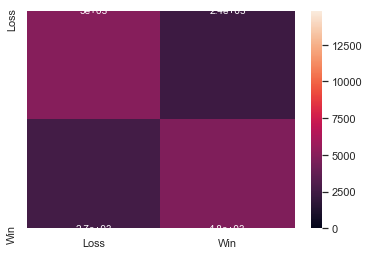

INFO:util.model_util:Saving model file: ../models/adaboostclassifier-1998-2018-diff-ohe.pkl
INFO:util.model_util:Reading report: ../reports/summary.csv


Saving report: ../reports/summary.csv


In [5]:
for model in models:
    print(f'\n\nRunning {type(model).__name__}')
    mw = mu.ModelWrapper(model,
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                    column_filters = column_filters)
    mw.fit(X_train, y_train)
    predict = mw.predict(X_test)
    mw.analyze(y_test)
    plt.show()
    mw.save()

# Summary

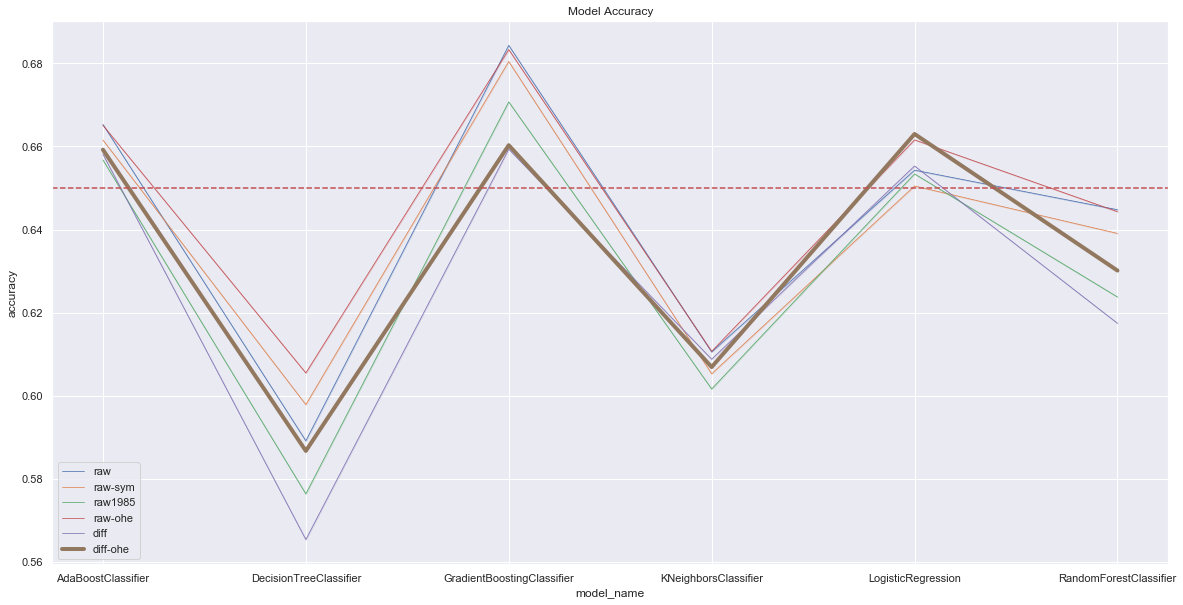

In [6]:
report = pd.read_csv(ModelWrapper.REPORT_FILE)

f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

Best Model: LogisticRegression


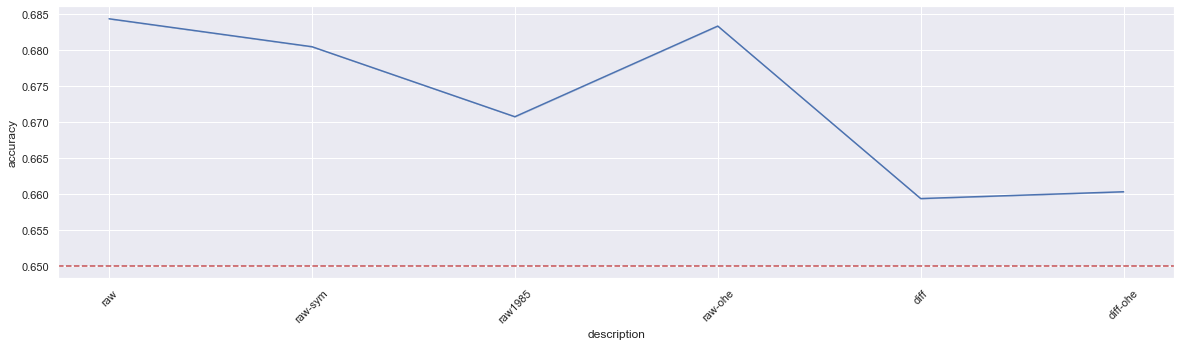

In [7]:
best_model = report.loc[report[report.description == DESCRIPTION].accuracy.idxmax()].model_name
print(f'Best Model: {best_model}')

dt_report = report[(report.model_name == 'GradientBoostingClassifier')]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.axhline(0.65, ls='--', color='r')
_ = a.set_label(f"{best_model} Accuracy")
_ = plt.xticks(rotation=45)


In [8]:
print(f'Last Finished: {datetime.now().strftime(DATE_FORMAT)}')

Last Finished: 2019-10-28 14:10
